### Import Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

### Import data into tensorflow dataset object

https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


Each element in the dataset is a tuple. The first element is a batch of 32 elements of images. The second element is a batch of 32 elements of class labels.

### Visualize Some Images from Dataset

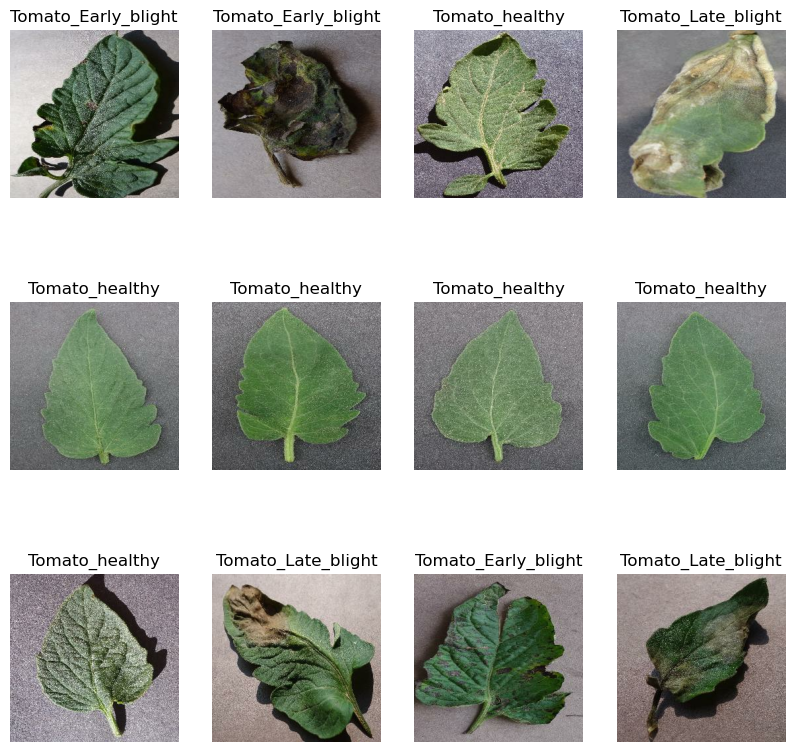

In [8]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Split Dataset
The dataset should be bifurcated into 3 subsets:
1. Training - dataset used while training
2. Validation - dataset to be tested against while training
3. Test - datset to be tested against after a model has been trained

In [9]:
len(dataset)

141

In [10]:
train_size = 0.8
len(dataset) * train_size

112.80000000000001

In [11]:
train_ds = dataset.take(113)
len(train_ds)

113

In [12]:
test_ds = dataset.skip(113)
len(test_ds)

28

In [13]:
val_size = 0.1
len(dataset) * val_size

14.100000000000001

In [14]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [15]:
test_ds = test_ds.skip(14)
len(test_ds)

14

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

112

In [19]:
len(val_ds)

14

In [20]:
len(test_ds)

15

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before feeding the images to the network, I need to resize it to the desired size. To improve model performance, I will normalize the image pixel value (keeping them in the range of 0 to 1 and by dividing by 256). This will happen while training as well as inference. Then I can add that as a layer in the Sequential Model.

In [23]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

#### Data Augmentation
Data Augmentation is needed when we have less data. This boosts the accuracy of the model.

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

##### Applying Data Augmentation to the Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
I will use a Convoluted Neural Network (CNN) with a Softmax application in the output layer. I will also add the initial layers for resizing, normalization, and Data Augmentation.

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\niles\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model
I will use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric.

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 54s 444ms/step - accuracy: 0.4359 - loss: 1.0477 - val_accuracy: 0.6384 - val_loss: 0.8177
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 437ms/step - accuracy: 0.6543 - loss: 0.7432 - val_accuracy: 0.7121 - val_loss: 0.5836
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - accuracy: 0.7691 - loss: 0.5205 - val_accuracy: 0.7991 - val_loss: 0.5000
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 412ms/step - accuracy: 0.8352 - loss: 0.4108 - val_accuracy: 0.7433 - val_loss: 0.8382
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 414ms/step - accuracy: 0.8473 - loss: 0.3872 - val_accuracy: 0.8125 - val_loss: 0.4426
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 410ms/step - accuracy: 0.8650 - loss: 0.3138 - val_accuracy: 0.8795 - val_loss: 0.2886
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 413ms/step - accuracy: 0.8760 - loss: 0.2962 - val_accuracy: 0.7723 - val_loss: 0.6506
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 418ms/step - accuracy: 0.8907 - loss: 0

In [31]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9766 - loss: 0.1361


**I get 97.66% accuracy for the test dataset - considered to be a pretty good accuracy**

In [32]:
scores

[0.11897895485162735, 0.9791666865348816]

`scores` is a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 112}

In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

`accuracy`, `loss`, `val_accuracy`, and `val_loss` are a python list containing values of loss, accuracy, etc. at the end of each epoch.

In [36]:
type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

50

In [38]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.991466760635376,
 0.7002780437469482,
 0.5081354975700378,
 0.40696385502815247,
 0.34737110137939453]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

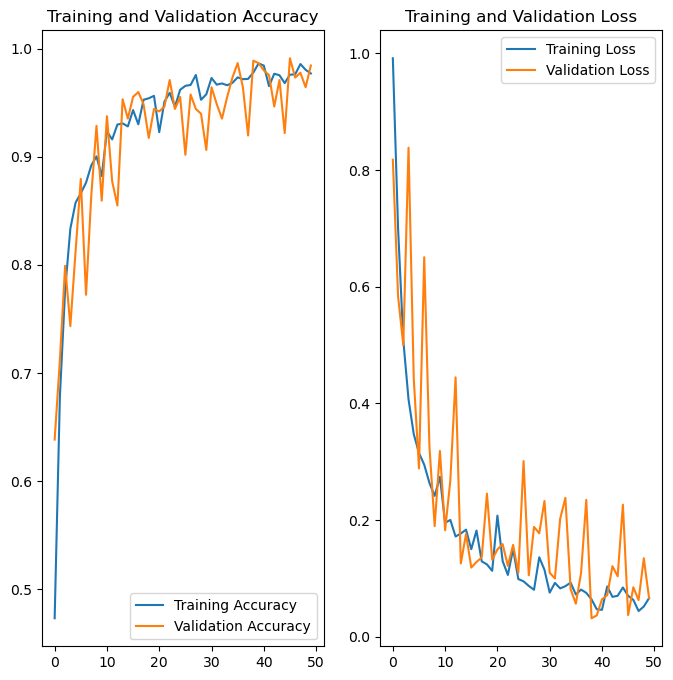

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run Prediction on a Sample Image

first image to predict
actual label: Tomato_Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
predicted label: Tomato_Early_blight


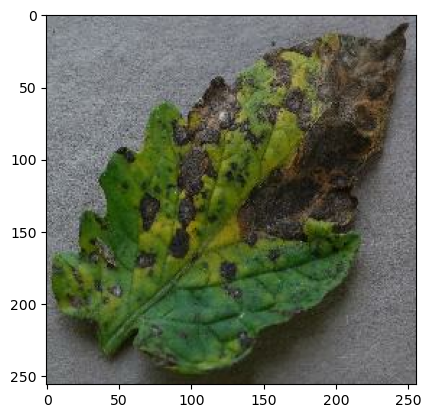

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Function for Inference

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Run inference on a few sample images.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


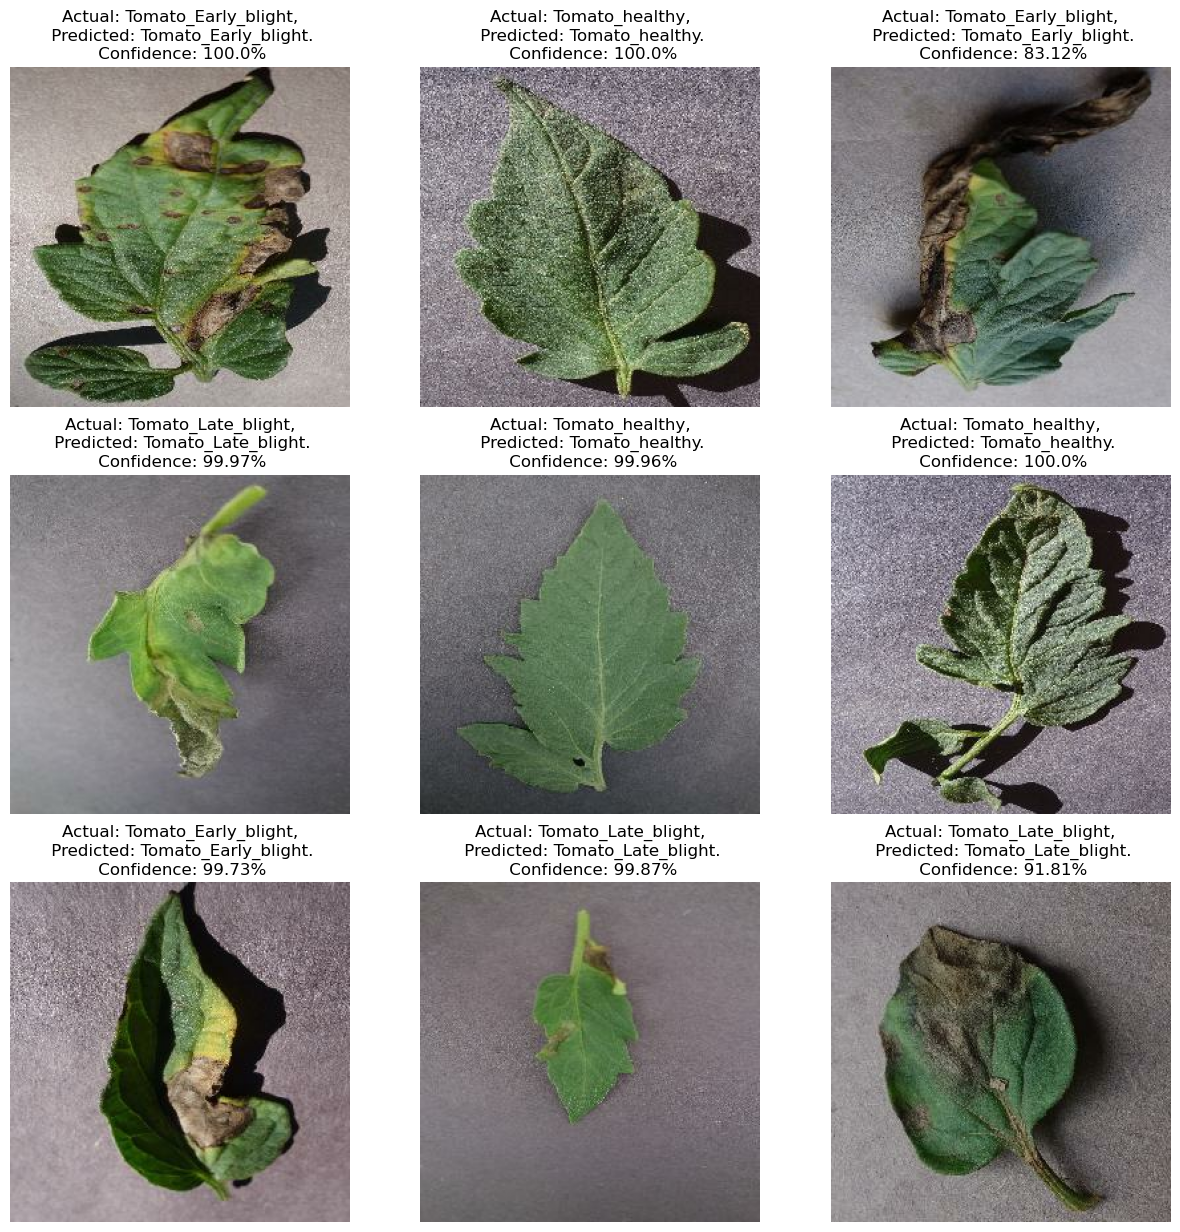

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Save the Model

In [49]:
import os

notebook_dir = os.path.dirname(os.path.realpath("__file__"))

models_dir = os.path.join(notebook_dir, "models")

os.makedirs(models_dir, exist_ok=True)

model_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()]
model_version = max(model_versions, default=0) + 1

model.save(f"{models_dir}/model_{model_version}.keras")